## Laboratorio 03 
### Histogram of Gradients (HOG) de Dalal & Triggs
- Sara Echeverría 21371
- Melissa Pérez 21385
- Ricardo Mendez 21289

Repositorio: https://github.com/MelissaPerez09/Lab03-CC3102

In [1]:
# libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog

### Task 01
Convertir una imagen a escala de grises y redimensionarla según un factor de escala

In [2]:
def preprocess_image(image_path, k=1):
    image = cv2.imread(image_path)
    
    # gray scale transformation
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # output image size
    new_size = (64 * k, 128 * k)
    
    # resize the image
    resized_image = cv2.resize(gray_image, new_size, interpolation=cv2.INTER_AREA)
    
    return resized_image

In [3]:
# show result
def convert_grays(image_path, k):
    processed_image = preprocess_image(image_path, k)
    plt.imshow(processed_image, cmap='gray')
    plt.axis('off')
    plt.title("Grayscale Image")
    plt.show()

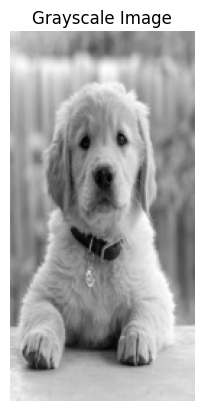

In [4]:
convert_grays("./img/golden.jpeg", 2)

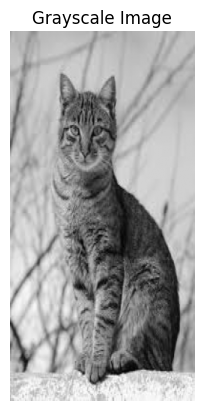

In [5]:
convert_grays("./img/cat.jpeg", 4)

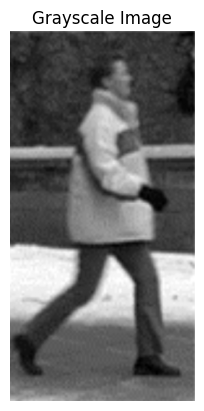

In [6]:
convert_grays("./img/person.png", 4)

### Task 02
Calcular la magnitud y el ángulo del gradiente de una imagen en escala de grises utilizando los filtros de Prewitt y Sobel.

In [7]:
# Prewitt filter
def apply_prewitt(image):
    # Prewitt kernels
    kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    
    # apply filters
    prewitt_x = cv2.filter2D(image, -1, kernel_x)
    prewitt_y = cv2.filter2D(image, -1, kernel_y)
    
    # calculate the magnitude of gradients
    magnitude = cv2.addWeighted(prewitt_x, 0.5, prewitt_y, 0.5, 0)
    
    # Calcular la orientación del gradiente y llevarla al rango [0, 180)
    orientation = np.arctan2(prewitt_y, prewitt_x) * (180 / np.pi)
    orientation = np.mod(orientation, 180)
    
    return magnitude, orientation

In [8]:
# Sobel filter
def apply_sobel(image):
    # apply Sobel filters in x and y directions
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # calculate the magnitude of gradients
    magnitude = cv2.magnitude(sobel_x, sobel_y)
    
    # calculate the orientation of the gradient and scale it to [0, 180)
    orientation = np.arctan2(sobel_y, sobel_x) * (180 / np.pi)
    orientation = np.mod(orientation, 180)
    
    return magnitude, orientation

In [9]:
# Show filter result
def show_filter_result(type, image_path, k):
    if type == "prewitt":
        processed_image = preprocess_image(image_path, k)
        magnitude, orientation = apply_prewitt(processed_image)
        filter_title = "Prewitt Filter"
    elif type == "sobel":
        processed_image = preprocess_image(image_path, k)
        magnitude, orientation = apply_sobel(processed_image)
        filter_title = "Sobel Filter"
    
    plt.figure(figsize=(4, 4))
    plt.suptitle(filter_title, fontsize=16)

    plt.subplot(1, 2, 1)
    plt.imshow(magnitude, cmap='gray')
    plt.axis('off')
    plt.title("Magnitude (µ)")

    plt.subplot(1, 2, 2)
    plt.imshow(orientation, cmap='gray')
    plt.axis('off')
    plt.title("Orientation (θ)")
    plt.show()

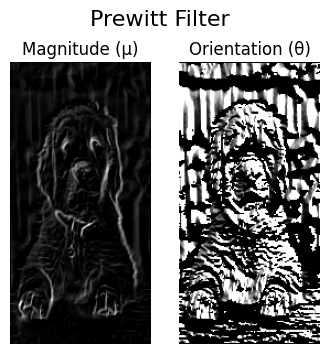

In [10]:
show_filter_result("prewitt", "./img/golden.jpeg", 2)

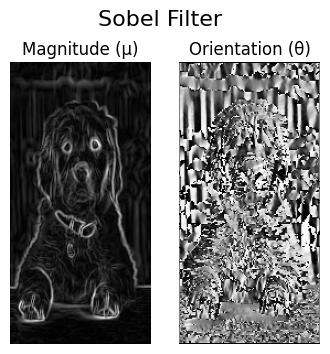

In [11]:
show_filter_result("sobel", "./img/golden.jpeg", 2)

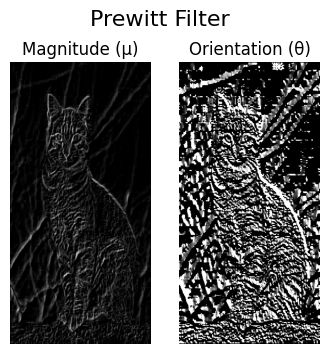

In [12]:
show_filter_result("prewitt", "./img/cat.jpeg", 4)

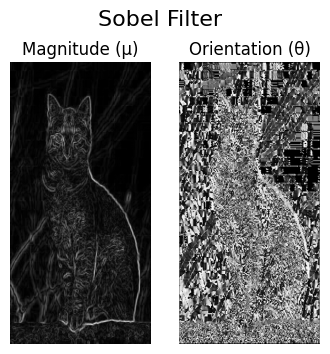

In [13]:
show_filter_result("sobel", "./img/cat.jpeg", 4)

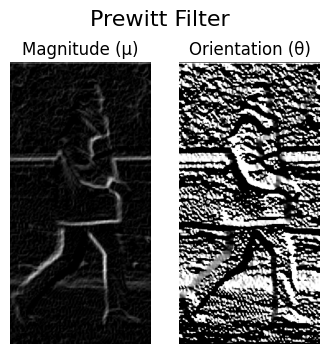

In [14]:
show_filter_result("prewitt", "./img/person.png", 4)

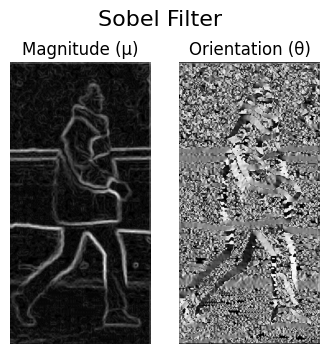

In [15]:
show_filter_result("sobel", "./img/person.png", 4)

### Task 03
Construir un conjunto de bloques de tamaño especificado para almacenar la magnitud y el ángulo del gradiente de la imagen.

In [16]:
def construct_block_stack(magnitude, angle, block_size=16):
    if block_size % 4 != 0:
        raise ValueError("block_size must be a multiple of 4.")
    
    stride = block_size // 2
    M = (magnitude.shape[0] - block_size) // stride + 1
    N = (magnitude.shape[1] - block_size) // stride + 1

    magnitude_stack = np.zeros((M, N, block_size, block_size))
    angle_stack = np.zeros((M, N, block_size, block_size))

    for i in range(M):
        for j in range(N):
            start_row = i * stride
            start_col = j * stride
            magnitude_stack[i, j] = magnitude[start_row:start_row + block_size, start_col:start_col + block_size]
            angle_stack[i, j] = angle[start_row:start_row + block_size, start_col:start_col + block_size]

    return magnitude_stack, angle_stack

In [17]:
magnitude, angle =  apply_sobel(preprocess_image("./img/person.png", 4))
m_stack, a_stack = construct_block_stack(magnitude, angle, block_size=16)
print("Magnitude Stack Shape:", m_stack.shape)
print("Angle Stack Shape:", a_stack.shape)

Magnitude Stack Shape: (63, 31, 16, 16)
Angle Stack Shape: (63, 31, 16, 16)


### Task 04
Generar histogramas de gradientes a partir de los bloques calculados, asignando votos a los bines mediante interpolación bilineal.

In [18]:
def gradients_histogram(m_stack, a_stack, num_bins=9, epsilon=1e-6):
    hist_stack = np.zeros((m_stack.shape[0], m_stack.shape[1], num_bins))
    
    # Normalize angles to [0, 180)
    a_stack = np.mod(a_stack, 180)
    
    # Calculate bin width
    bin_width = 180 / num_bins
    
    for i in range(m_stack.shape[0]):
        for j in range(m_stack.shape[1]):
            hist = np.zeros(num_bins)
            magnitude = m_stack[i, j]
            angle = a_stack[i, j]
            
            for x in range(magnitude.shape[0]):
                for y in range(magnitude.shape[1]):
                    theta = angle[x, y]
                    mu = magnitude[x, y]
                    
                    # Find the two adjacent bins
                    b1 = int(theta // bin_width)
                    b2 = (b1 + 1) % num_bins
                    
                    # Calculate weights
                    w1 = (b2 * bin_width - theta) / bin_width
                    w2 = (theta - b1 * bin_width) / bin_width
                    
                    # Ensure weights sum to 1
                    w1 = max(0, w1)
                    w2 = max(0, w2)
                    
                    # Distribute votes
                    hist[b1] += w1 * mu
                    hist[b2] += w2 * mu
            
            # Normalize histogram using Euclidean norm
            hist /= np.sqrt(np.sum(hist ** 2) + epsilon)
            hist_stack[i, j] = hist
    
    return hist_stack

In [19]:
hist = gradients_histogram(m_stack, a_stack)

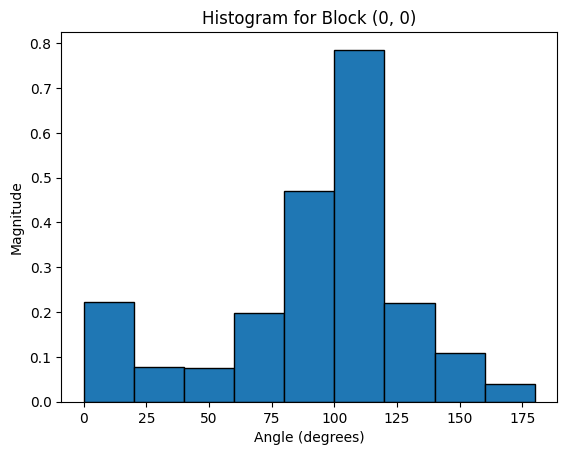

In [20]:
def plot_histogram(hist, block_row, block_col):
    block_hist = hist[block_row, block_col]
    num_bins = block_hist.shape[0]
    bin_edges = np.linspace(0, 180, num_bins + 1)

    plt.bar(bin_edges[:-1], block_hist, width=180 / num_bins, align='edge', edgecolor='black')
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Magnitude")
    plt.title(f"Histogram for Block ({block_row}, {block_col})")
    plt.show()

plot_histogram(hist, 0, 0)

### Task 05
Visualizar los histogramas de cada bloque en una imagen con fondo negro, representando las direcciones de los gradientes.

In [21]:
def visualize_block_histogram(hist, block_size=8, num_bins=9):
    # create a black block to draw the histogram on
    block_image = np.zeros((block_size, block_size), dtype=np.float32)
    
    # center of the block
    center = (block_size // 2, block_size // 2)
    
    # calculate the angle in radians for each bin
    angle_step = 180 / num_bins
    angles = np.arange(0, 180, angle_step) * (np.pi / 180)

    for bin_idx, magnitude in enumerate(hist):
        angle = angles[bin_idx]
        # compute the line direction based on the angle
        dx = (block_size // 2 - 1) * np.cos(angle)
        dy = (block_size // 2 - 1) * np.sin(angle)

        x1 = int(center[0] - dx)
        y1 = int(center[1] - dy)
        x2 = int(center[0] + dx)
        y2 = int(center[1] + dy)
        
        # draw a line with intensity proportional to the histogram value
        cv2.line(block_image, (x1, y1), (x2, y2), color=float(magnitude), thickness=1)
    
    return block_image

In [22]:
def visualize_all_blocks(hist_stack, block_size=8):
    # get number of blocks and bins
    M, N, num_bins = hist_stack.shape
    height = M * block_size
    width = N * block_size
    hog_image = np.zeros((height, width), dtype=np.float32)

    for i in range(M):
        for j in range(N):
            block_hist = hist_stack[i, j]
            vis_block = visualize_block_histogram(block_hist, block_size)
            row_start = i * block_size
            col_start = j * block_size
            # place the visual block in the correct position
            hog_image[row_start:row_start + block_size, col_start:col_start + block_size] = vis_block

    return hog_image

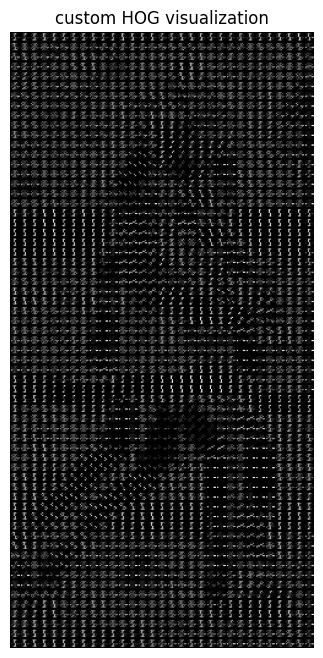

In [23]:
# visualize the full hog representation
hog_visualization = visualize_all_blocks(hist, block_size=8)

plt.figure(figsize=(8, 8))
plt.imshow(hog_visualization, cmap='gray')
plt.title("custom HOG visualization")
plt.axis('off')
plt.show()

### Task 06
Comparar la implementación propia del algoritmo HOG con la versión de la función _hog_ de _scikit-image_.

In [24]:
# load the image using OpenCV (same as before)
image = cv2.imread("./img/person.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# convert to grayscale (skimage uses float64, values between 0 and 1)
gray_image = rgb2gray(image_rgb)

# resize to (128k, 64k), here k = 2 → (256, 128)
resized_gray = resize(gray_image, (256, 128), anti_aliasing=True)

In [25]:
# compute HOG using skimage
fd, hog_image = hog(
    resized_gray, 
    orientations=9, 
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), 
    visualize=True
)

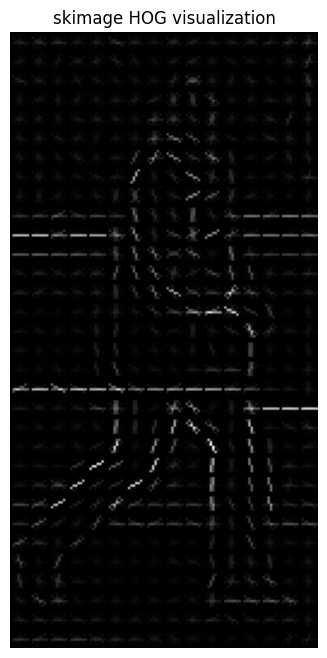

In [26]:
plt.figure(figsize=(8, 8))
plt.imshow(hog_image, cmap='gray')
plt.title("skimage HOG visualization")
plt.axis('off')
plt.show()

### Task 07
Implementar un método de detección de personas usando OpenCV y visualizar los resultados sobre imágenes de prueba.

In [27]:
def detect_people(image_path):
    I = cv2.imread(image_path)

    # HOG and detection
    hog2 = cv2.HOGDescriptor()
    hog2.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    # detect people
    locations, confidence = hog2.detectMultiScale(I, winStride=(2, 2), padding=(1, 1), scale=1.05)

    # rectangle the detected people
    for (x, y, w, h) in locations:
        cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 1)

    # Convertir a RGB para mostrar correctamente en Matplotlib
    I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen con detecciones
    plt.figure(figsize=(9, 3))
    plt.imshow(I_rgb)
    plt.axis('off')
    plt.title("detection with HOG + SVM")
    plt.show()

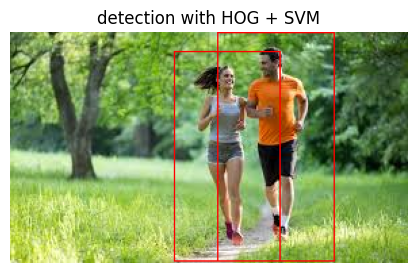

In [28]:
detect_people("./img/runners.jpeg")

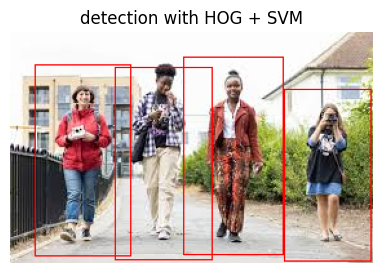

In [29]:
detect_people("./img/street.jpeg")